In [1]:
# @ Tiyasa
# 06/19/2024


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import time

In [3]:
def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    # Sample depths (t_is_c). See Equation (2) in Section 4.
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    # Calculate the points along the rays (r_ts_c) using the ray origins (os), sampled
    # depths (t_is_c), and ray directions (ds). See Section 4: r(t) = o + t * d.
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)

In [4]:
def get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds):
    # See text surrounding Equation (5) in Section 5.2 and:
    # https://stephens999.github.io/fiveMinuteStats/inverse_transform_sampling.html#discrete_distributions.

    # Define PDFs (pdfs) and CDFs (cdfs) from weights (w_is_c).
    w_is_c = w_is_c + 1e-5
    pdfs = w_is_c / torch.sum(w_is_c, dim=-1, keepdim=True)
    cdfs = torch.cumsum(pdfs, dim=-1)
    cdfs = torch.cat([torch.zeros_like(cdfs[..., :1]), cdfs[..., :-1]], dim=-1)

    # Get uniform samples (us).
    us = torch.rand(list(cdfs.shape[:-1]) + [N_f]).to(w_is_c)

    # Use inverse transform sampling to sample the depths (t_is_f).
    idxs = torch.searchsorted(cdfs, us, right=True)
    t_i_f_bottom_edges = torch.gather(t_is_c, 2, idxs - 1)
    idxs_capped = idxs.clone()
    max_ind = cdfs.shape[-1]
    idxs_capped[idxs_capped == max_ind] = max_ind - 1
    t_i_f_top_edges = torch.gather(t_is_c, 2, idxs_capped)
    t_i_f_top_edges[idxs == max_ind] = t_f
    t_i_f_gaps = t_i_f_top_edges - t_i_f_bottom_edges
    u_is_f = torch.rand_like(t_i_f_gaps).to(os)
    t_is_f = t_i_f_bottom_edges + u_is_f * t_i_f_gaps

    # Combine the coarse (t_is_c) and fine (t_is_f) depths and sort them.
    (t_is_f, _) = torch.sort(torch.cat([t_is_c, t_is_f.detach()], dim=-1), dim=-1)
    # Calculate the points along the rays (r_ts_f) using the ray origins (os), depths
    # (t_is_f), and ray directions (ds). See Section 4: r(t) = o + t * d.
    r_ts_f = os[..., None, :] + t_is_f[..., :, None] * ds[..., None, :]
    return (r_ts_f, t_is_f)

In [5]:
def render_radiance_volume(r_ts, ds, chunk_size, F, t_is):
    # Use the network (F) to predict colors (c_is) and volume densities (sigma_is) for
    # 3D points along rays (r_ts) given the viewing directions (ds) of the rays. See
    # Section 3 and Figure 7 in the Supplementary Materials.
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))
    c_is = []
    sigma_is = []
    # The network processes batches of inputs to avoid running out of memory.
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        preds = F(r_ts_batch, ds_batch) ## here the network is being used
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])

    c_is = torch.cat(c_is).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])

    # Calculate the distances (delta_is) between points along the rays. The differences
    # in depths are scaled by the norms of the ray directions to get the final
    # distances. See text following Equation (3) in Section 4.
    delta_is = t_is[..., 1:] - t_is[..., :-1]
    # "Infinity". Guarantees last alpha is always one.
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

    # Calculate the alphas (alpha_is) of the 3D points using the volume densities
    # (sigma_is) and distances between points (delta_is). See text following Equation
    # (3) in Section 4 and https://en.wikipedia.org/wiki/Alpha_compositing.
    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    # Calculate the accumulated transmittances (T_is) along the rays from the alphas
    # (alpha_is). See Equation (3) in Section 4. T_i is "the probability that the ray
    # travels from t_n to t_i without hitting any other particle".
    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    # Guarantees the ray makes it at least to the first step. See:
    # https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L142,
    # which uses tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True).
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    # Calculate the weights (w_is) for the colors (c_is) along the rays using the
    # transmittances (T_is) and alphas (alpha_is). See Equation (5) in Section 5.2:
    # w_i = T_i * (1 - exp(-sigma_i * delta_i)).
    w_is = T_is * alpha_is

    # Calculate the pixel colors (C_rs) for the rays as weighted (w_is) sums of colors
    # (c_is). See Equation (5) in Section 5.2: C_c_hat(r) = Σ w_i * c_i.
    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return (C_rs, w_is)

In [6]:
def run_one_iter_of_nerf(
    ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c, N_f, t_f, F_f
):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    (C_rs_c, w_is_c) = render_radiance_volume(r_ts_c, ds, chunk_size, F_c, t_is_c)

    (r_ts_f, t_is_f) = get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds)
    (C_rs_f, _) = render_radiance_volume(r_ts_f, ds, chunk_size, F_f, t_is_f)

    return (C_rs_c, C_rs_f)

In [13]:
class vanilla_skip_nerf_12_v1(nn.Module):
    def __init__(self):
        super().__init__()
        self.L_pos = 10
        self.L_dir = 4
        pos_enc_features = 3+3*2*self.L_pos 
        dir_enc_features = 3+3*2*self.L_dir 
        in_pos_features1 = pos_enc_features
        
        num_neurons = 256
        in_dir_features2 = num_neurons+dir_enc_features
       
        self.mlp_block_1 = nn.Sequential(
            nn.Linear(in_pos_features1,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU())
        self.mlp_block_2 = nn.Sequential(
            nn.Linear(in_dir_features2, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU())
        in_features_3 = num_neurons
        self.mlp_block_3 = nn.Sequential(
            nn.Linear(in_features_3,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU())
        self.sigma_layer = nn.Linear(num_neurons, num_neurons+1) ## In next version just change the number of neurons
        self.pre_final_layer = nn.Sequential(nn.Linear(num_neurons, num_neurons//2),
                                            nn.ReLU())
        self.final_layer= nn.Sequential(nn.Linear(num_neurons//2,3,nn.Sigmoid()))
        
    def forward(self, rays_samples,view_dirs):
        rays_samples_encoded = [rays_samples]
        for l_pos in range(self.L_pos):
            rays_samples_encoded.append(torch.sin(2**l_pos*torch.pi*rays_samples))
            rays_samples_encoded.append(torch.cos(2**l_pos*torch.pi*rays_samples))
        
        rays_samples_encoded = torch.cat(rays_samples_encoded, dim=-1) ##(16K *60)
#         print(f'shape of rays_samples_encoded:{rays_samples_encoded.shape}')
        
        
        view_dirs = view_dirs/view_dirs.norm(p=2, dim=-1).unsqueeze(-1)
        view_dirs_encoded = [view_dirs]
        for l_dir in range(self.L_dir):
            view_dirs_encoded.append(torch.sin(2**l_dir*torch.pi*view_dirs))
            view_dirs_encoded.append(torch.cos(2**l_dir*torch.pi*view_dirs))
        
        view_dirs_encoded = torch.cat(view_dirs_encoded, dim=-1) ##(16*24)
        
        
#         print(f'shape of view_dirs_encoded:{view_dirs_encoded.shape}')
        
        outputs_mlp_block1 = self.mlp_block_1(rays_samples_encoded)
#         print(f'outputs_mlp_block1:{outputs_mlp_block1.shape}')
        outputs_mlp_block2 = self.mlp_block_2(torch.cat([view_dirs_encoded,outputs_mlp_block1], dim=-1)) ##concatenating directional inputs to outputs of previous MLP
#         print(f'outputs_mlp_block2:{outputs_mlp_block2.shape}')
        # Sum the outputs 
        outputs_combined = outputs_mlp_block1+outputs_mlp_block2 ## Here goes the skip connections 
#         print(f'outputs_combined:{outputs_combined.shape}')
#         output_concat = torch.cat([outputs_combined,view_dirs_encoded],dim=-1) ## We have just concatenated the directional encodings
#         print(f'shape of output concat: {output_concat.shape}') 

        # Now Concatenate with positional and directional embeddings
        outputs_mlp_block3 = self.mlp_block_3(outputs_combined)
#         print(f'outputs_mlp_block3:{outputs_mlp_block3.shape}')
        ## At this point we are again concatenating just the directional stuff
        outputs = self.sigma_layer(outputs_mlp_block3)
#         print(f'After passing sigma layer: {outputs_mlp_block3.shape}')
        sigma_is = torch.relu(outputs[:,0])
#         print(f'sigma is: {sigma_is.shape}')
        outputs1 = self.pre_final_layer(outputs[:,1:])
#         print(f'shape of output after passing pre_final_layer: {outputs1.shape}')
        c_is = self.final_layer(outputs1)
#         print(f'shape of c_is:{c_is.shape}')
        return {"c_is":c_is, "sigma_is": sigma_is}
        
        
        
        

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

    #  VOLUMETRIC RENDERING IN NERF - SEC:5.3
coarse_mlp = vanilla_skip_nerf_12_v1().to(device)
fine_mlp = vanilla_skip_nerf_12_v1().to(device)

    # Number of query points passed through the MLP at a time.
chunk_size = 512 *16 #1024 * 32

    # Number of training rays per iteration. SEC:5.3
batch_img_size = 32 #64
n_batch_pix = batch_img_size ** 2

    # INITIALIZE OPTIMIZER. SEC 5.3
lr = 5e-4
optimizer = optim.Adam(list(coarse_mlp.parameters()) + list(fine_mlp.parameters()), lr=lr)
criterion = nn.MSELoss()
    # The learning rate decays exponentially. Section 5.3
lrate_decay = 250
decay_steps = lrate_decay * 1000
decay_rate = 0.1

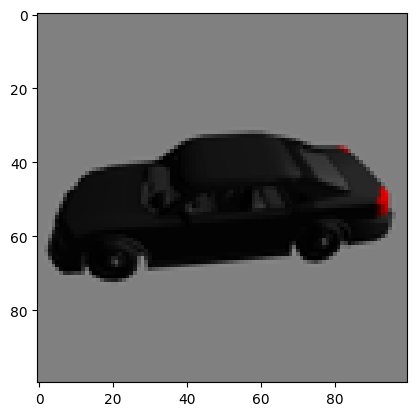

In [15]:
data_f = "C:/Users/TIYASA/NeRF_from_scratch/data.npz"
data = np.load(data_f)

    # Set up initial ray origin (init_o) and ray directions (init_ds). These are the
    # same across samples, we just rotate them based on the orientation of the camera.
    # See Section 4.
images = data["images"] / 255
img_size = images.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
# We want the zs to be negative ones, so we divide everything by the focal length
# (which is in pixel units).
camera_coords = pixel_coords / focal
init_ds = camera_coords.to(device)
init_o = torch.Tensor(np.array([0, 0, float(data["camera_distance"])])).to(device)

test_idx = 150
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)

poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 0.1422053724527359


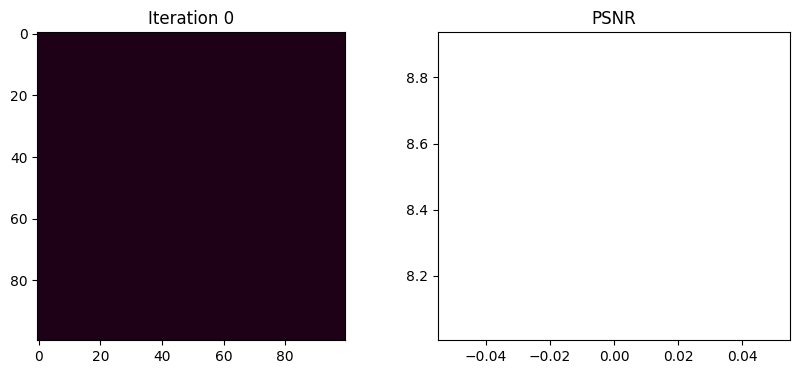

KeyboardInterrupt: 

In [16]:
# VOLUME RENDERING HYPER-PARAMETERS - SEC:4
t_n = 2.0  # Near bound.
t_f = 6.0  # Far bound.
num_coarse_sample = 64
num_fine_sample = 128
    # Bins used to sample depths along a ray. SEC:4 Eq2
"""
    Here we basically  we use a stratified (arranged in layers) sampling approach 
    where we partition [tn, tf ] into N evenly-spaced bins 
    and then draw one sample uniformly at random from within each bin 
"""
t_i_c_gap = (t_f - t_n) / num_coarse_sample
t_i_c_bin_edges = (t_n + torch.arange(num_coarse_sample) * t_i_c_gap).to(device)

train_idxs = np.arange(len(images)) != test_idx
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])
n_pix = img_size ** 2
pixel_ps = torch.full((n_pix,), 1 / n_pix).to(device)
psnrs = []
iternums = []
    # See Section 5.3.
num_iters = 6000
display_every = 200
coarse_mlp.train()
fine_mlp.train()
training_start_time = time.time()
for i in range(num_iters):
        # Sample image and associated pose.
    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]

        # Get rotated ray origins (os) and ray directions (ds). See Section 4.
    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

        # Sample a batch of rays.
        
     ## Global illumination techniques!   
    pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
    ## Why pix_idx_rows are exactly like the way they are
    pix_idx_rows = pix_idxs // img_size
    pix_idx_cols = pix_idxs % img_size
    ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
            batch_img_size, batch_img_size, -1
        )
    os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
            batch_img_size, batch_img_size, -1
        )

        # Run NeRF.
    (C_rs_c, C_rs_f) = run_one_iter_of_nerf(
            ds_batch,
            num_coarse_sample,
            t_i_c_bin_edges,
            t_i_c_gap,
            os_batch,
            chunk_size,
            coarse_mlp,
            num_fine_sample,
            t_f,
            fine_mlp,
        )
    target_img = images[target_img_idx].to(device)
    target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(C_rs_f.shape)
        # Calculate the mean squared error for both the coarse and fine MLP models and
        # update the weights. See Equation (6) in Section 5.3.
    loss = criterion(C_rs_c, target_img_batch) + criterion(C_rs_f, target_img_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

        # Exponentially decay learning rate. See Section 5.3 and:
        # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/.
    for g in optimizer.param_groups:
        g["lr"] = lr * decay_rate ** (i / decay_steps)

    if i % display_every == 0:
        coarse_mlp.eval()
        fine_mlp.eval()
        with torch.no_grad():
                (_, C_rs_f) = run_one_iter_of_nerf(
                    test_ds,
                    num_coarse_sample,
                    t_i_c_bin_edges,
                    t_i_c_gap,
                    test_os,
                    chunk_size,
                    coarse_mlp,
                    num_fine_sample,
                    t_f,
                    fine_mlp,
                )
        loss = criterion(C_rs_f, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_f.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        if i%1000 == 0:
            torch.save(fine_mlp.state_dict(), "C:/Users/TIYASA/NeRF_from_scratch/Nerf_Variation_1/checkpoint.pth")

        coarse_mlp.train() # weights get balanced for evaluation
        fine_mlp.train()
training_end_time = time.time()
total_training_time_seconds = training_end_time-training_start_time  # Replace this with your actual training time in seconds
formatted_time = time.strftime("%H:%M:%S", time.gmtime(total_training_time_seconds))
print("Completed Training!")
print(f'Total time required for training: {formatted_time}')

print("Saving model...")
torch.save(fine_mlp, "C:/Users/TIYASA/NeRF_from_scratch/Nerf_Variation_1/finalcheckpoint.pth")
print("Done!")

